## Kernel Attention analysis

In [1]:
import torch
import matplotlib.pyplot as plt

from src.Transformer import KernelAttention as KA

In [2]:
B, n_H, S, D = 1, 1, 64, 20

### Generate random $q, k, v$ vectors 

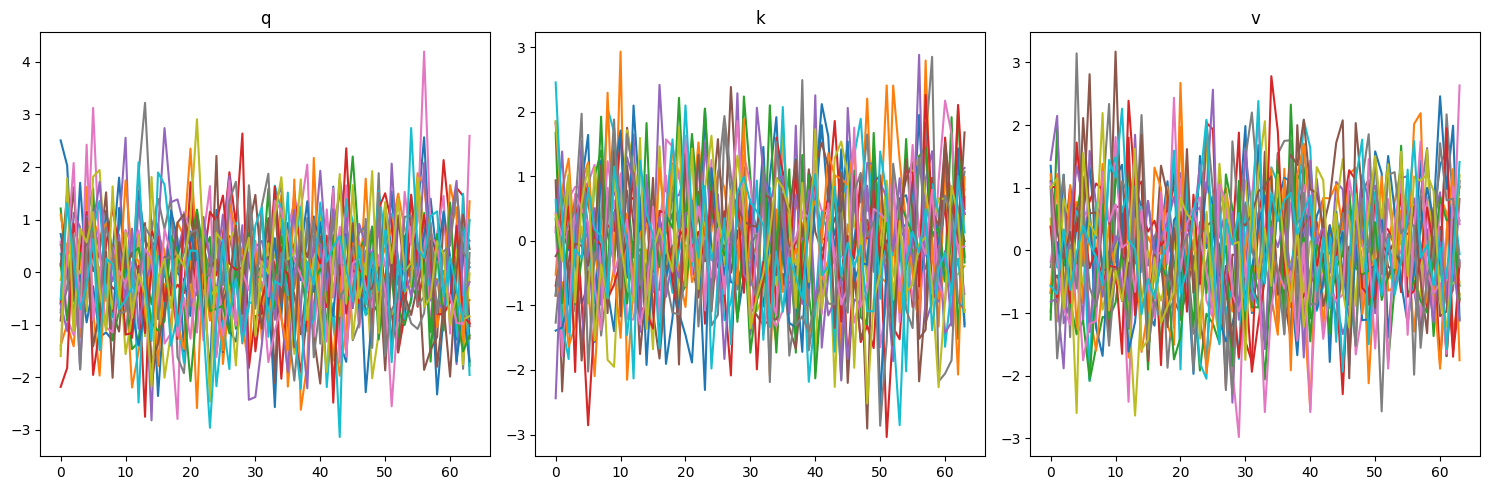

In [3]:
q = torch.randn(B, n_H, S, D)
k = torch.randn(B, n_H, S, D)
v = torch.randn(B, n_H, S, D)

mask = torch.tril(torch.ones((S, S)), diagonal=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(q.squeeze(), label="q")
ax2.plot(k.squeeze(), label="k")
ax3.plot(v.squeeze(), label="v")
ax1.set_title('q')
ax2.set_title('k')
ax3.set_title('v')
plt.tight_layout()

### Attention weights for all kernels

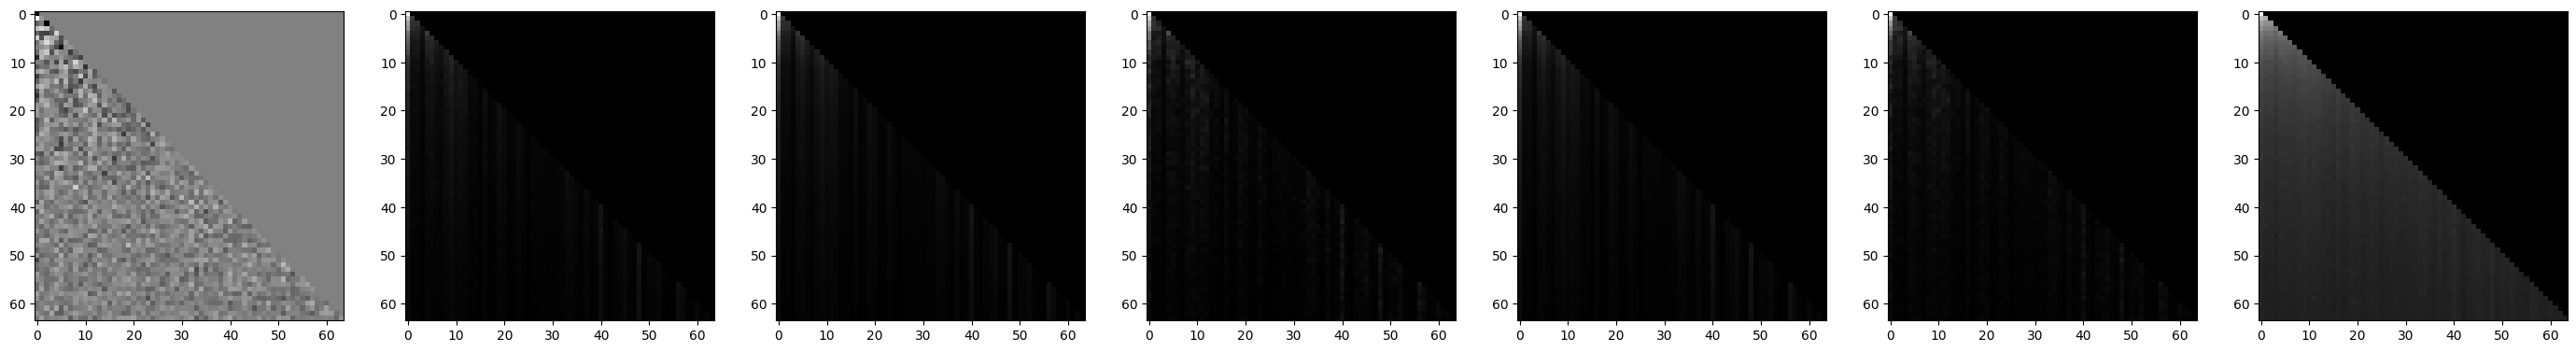

In [5]:
attns = [
    KA.LinearKernelAttention(),
    KA.SEKernelAttention(),
    KA.PeriodicKernelAttention(period=10),
    KA.LocallyPeriodicKernelAttention(period=10),
    KA.RationalQuadraticKernelAttention(),
    KA.ImplicitKernelAttention(),
    KA.ChangePointKernelAttention(period=10)
]

fig, axes = plt.subplots(1, len(attns), figsize=(len(attns)*5, 5))

for ax, attn in zip(axes, attns):
    _ = attn(q, k, v, mask)
    ax.imshow(attn.attention_weight.detach().squeeze(), cmap='gray')

### Squared exponential kernel

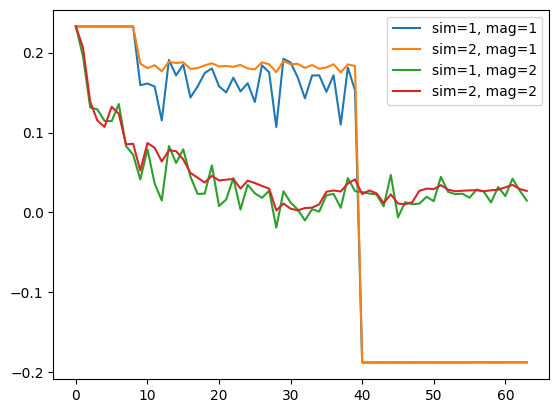

In [6]:
ps = [1, 2]

SE_kernels = [
    KA.SEKernelAttention(p_norm_sim=1, p_norm_mag=1),
    KA.SEKernelAttention(p_norm_sim=2, p_norm_mag=1),
    KA.SEKernelAttention(p_norm_sim=1, p_norm_mag=2),
    KA.SEKernelAttention(p_norm_sim=2, p_norm_mag=2),
]

for attn in SE_kernels:
    attn.eval()

ys = [attn(q, k, v, mask) for attn in SE_kernels]

for attn, y in zip(SE_kernels, ys):
    plt.plot(y.detach().squeeze().mean(dim=-1), label=f'sim={attn.p_norm_sim}, mag={attn.p_norm_mag}')

plt.legend()

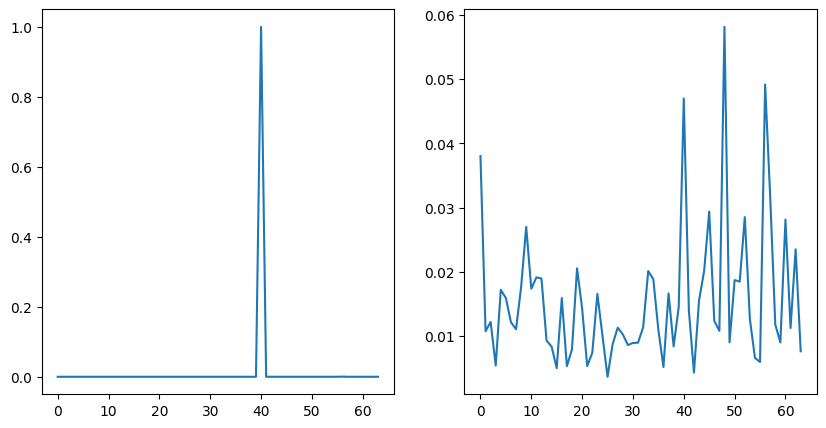

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

for w in SE_kernels[0].attention_weight.squeeze()[-1:]:
    ax1.plot(w.detach().squeeze())
        
for w in SE_kernels[-1].attention_weight.squeeze()[-1:]:
    ax2.plot(w.detach().squeeze())

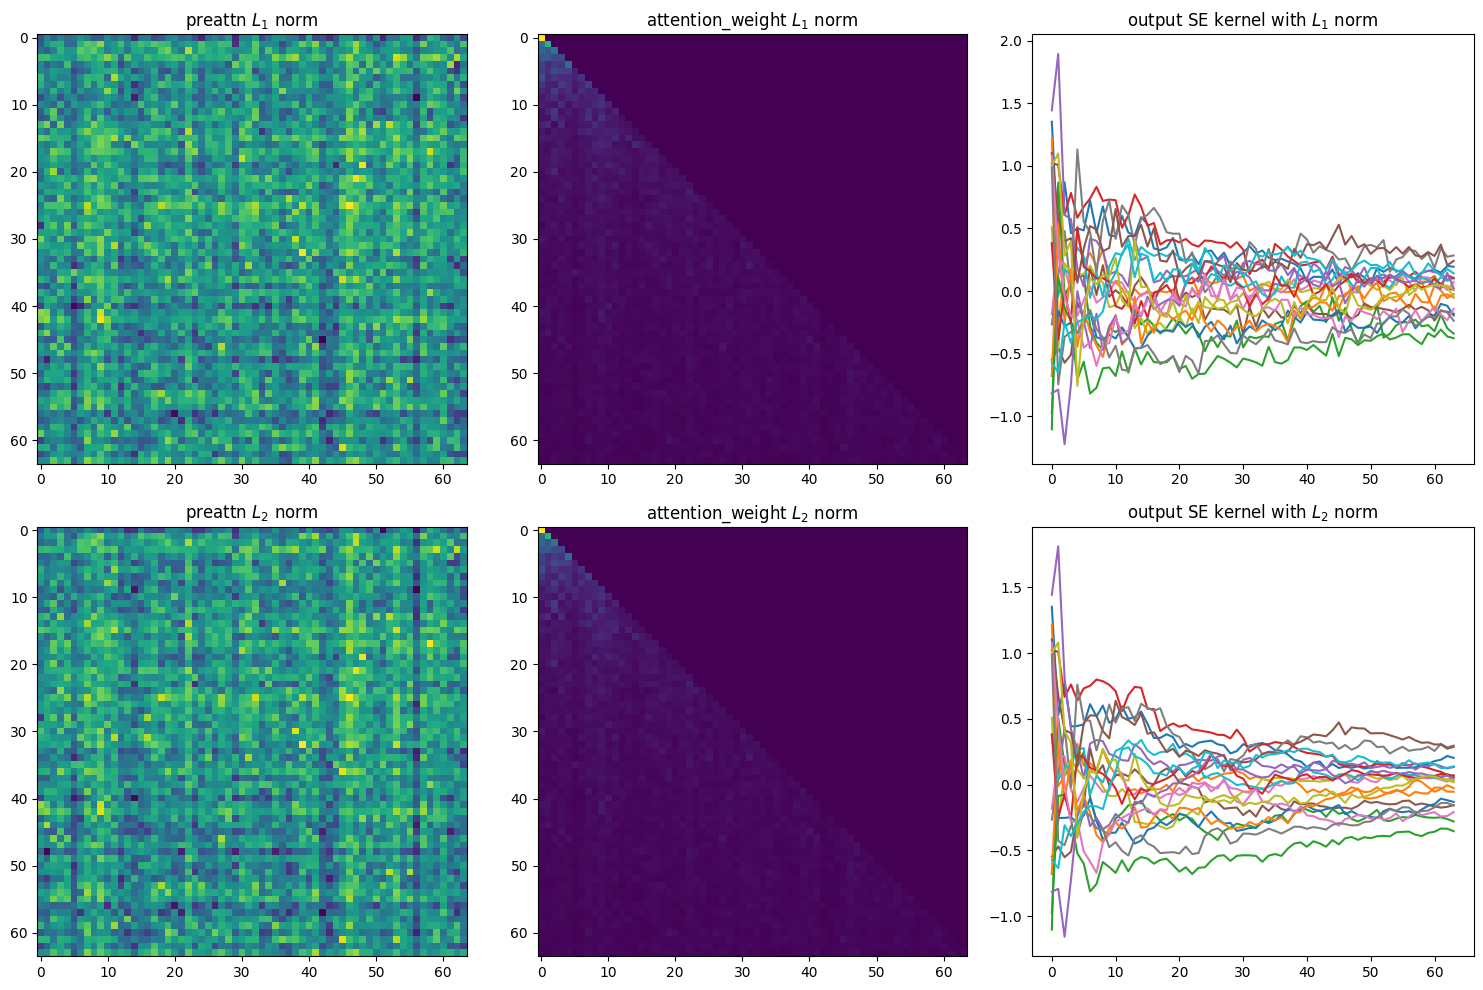

In [8]:
_, _, seq_len, d = q.shape

# query: (batch_size, n_heads, seq_len, d) --> (batch_size, n_heads, d, 1, seq_len)
# keys:  (batch_size, n_heads, seq_len, d) --> (batch_size, n_heads, d, seq_len, 1)
# diff:  (batch_size, n_heads, d, 1, seq_len) - (batch_size, n_heads, d, seq_len, 1) -> (batch_size, n_heads, d, seq_len, seq_len)
diff = (q[..., None].permute(0, 1, 3, 4, 2) - k[..., None].permute(0, 1, 3, 2, 4))

fig, (row_ax1, row_ax2) = plt.subplots(2, 3, figsize=(15, 10))

# preattn: (batch_size, n_heads, d, seq_len, seq_len) --> (batch_size, n_heads, seq_len, seq_len)
preattn1 = -torch.norm(diff, dim=2, p=1) / (2 * d**0.5)
preattn2 = -torch.norm(diff, dim=2, p=2) / (2 * d**0.5)

masked_preattn1 = preattn1.masked_fill(mask == 0, float('-inf'))
masked_preattn2 = preattn2.masked_fill(mask == 0, float('-inf'))

attention_weight1 = torch.softmax(masked_preattn1, dim=-1)
attention_weight2 = torch.softmax(masked_preattn2, dim=-1)

# out: (batch_size, n_heads, seq_len, key_dim)
out1 = attention_weight1 @ v
out2 = attention_weight2 @ v

row_ax1[0].imshow(preattn1.squeeze())
row_ax1[0].set_title(r'preattn $L_1$ norm')
row_ax2[0].imshow(preattn2.squeeze())
row_ax2[0].set_title(r'preattn $L_2$ norm')

row_ax1[1].imshow(attention_weight1.squeeze())
row_ax1[1].set_title(r'attention_weight $L_1$ norm')
row_ax2[1].imshow(attention_weight1.squeeze())
row_ax2[1].set_title(r'attention_weight $L_2$ norm')

row_ax1[2].plot(out1.squeeze())
row_ax1[2].set_title(r'output SE kernel with $L_1$ norm')
row_ax2[2].plot(out2.squeeze())
row_ax2[2].set_title(r'output SE kernel with $L_2$ norm')

plt.tight_layout()

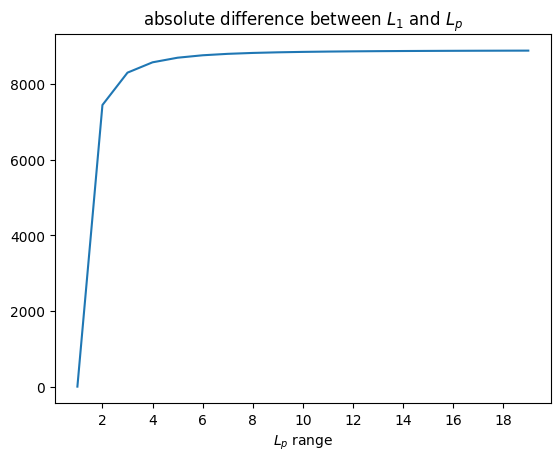

In [9]:
preattn1 = -torch.norm(diff, dim=2, p=1) / (2 * d**0.5)

diffs = []

lp_range = range(1, 20)

for i in lp_range:
    preattn2 = -torch.norm(diff, dim=2, p=i) / (2 * d**0.5)
    diffs.append(torch.sum(torch.abs(preattn1 - preattn2)))

ax = plt.figure().gca()
plt.plot(lp_range, diffs)
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('$L_p$ range')
plt.title('absolute difference between $L_1$ and $L_p$')
plt.show()

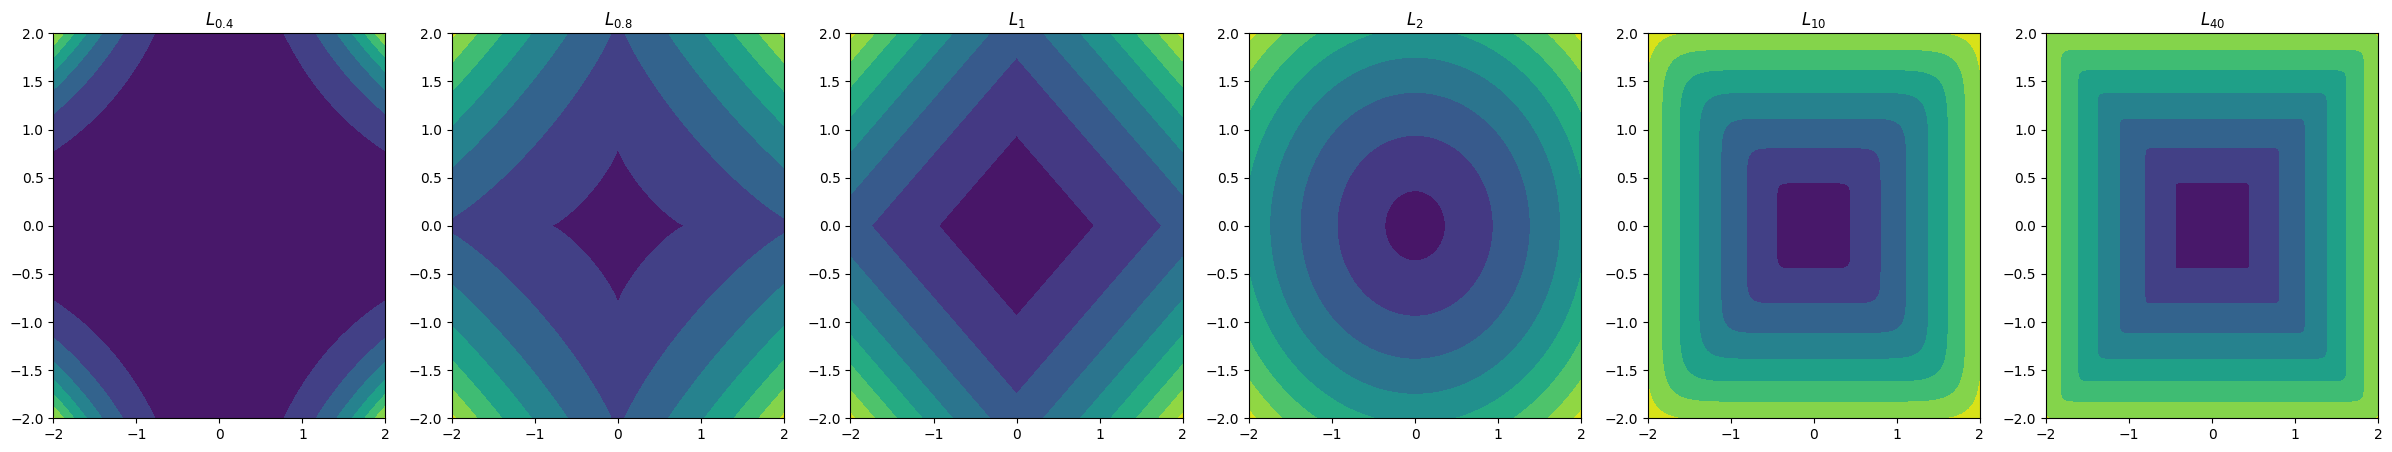

In [13]:
def rbf_cols(x, p):
    return torch.exp(torch.norm(x, p=p, dim=-1) / (2 * 1**.5))

xx, yy = torch.meshgrid(
    torch.linspace(-2, 2, 300),
    torch.linspace(-2, 2, 300),
    indexing='ij'
)
xy = torch.vstack((xx.flatten(), yy.flatten())).T

fig, axes = plt.subplots(1, 6, figsize=(30, 5))

ps = [0.4, 0.8, 1, 2, 10, 40]

for i, ax in zip(ps, axes):
    ax.set_title(f'$L_{{{i}}}$')
    ax.contourf(xx, yy, rbf_cols(xy, p=i).reshape(xx.shape))

### Periodic kernel

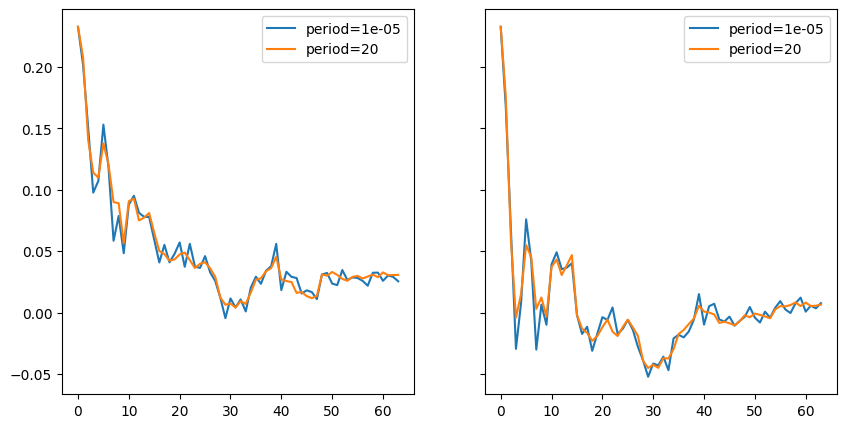

In [10]:
periods = [0.00001, 20]

Per_kernelsL1 = [KA.PeriodicKernelAttention(p_norm=2, period=p, include_magnitude=True) for p in periods]
for attn in Per_kernelsL1:
    attn.eval()

Per_kernelsL2 = [KA.PeriodicKernelAttention(p_norm=2, period=p, include_magnitude=False) for p in periods]
for attn in Per_kernelsL2:
    attn.eval()

ys1 = [attn(q, k, v, mask) for attn in Per_kernelsL1]
ys2 = [attn(q, k, v, mask) for attn in Per_kernelsL2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for p, y in zip(periods, ys1):
    ax1.plot(y.detach().squeeze().mean(dim=-1), label=f'period={p}')

for p, y in zip(periods, ys2):
    ax2.plot(y.detach().squeeze().mean(dim=-1), label=f'period={p}')

ax1.legend()
ax2.legend()

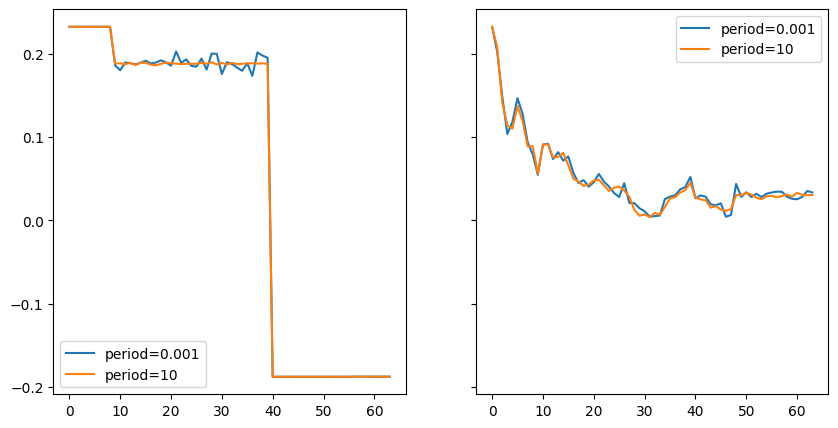

In [11]:
periods = [0.001, 10]

Per_kernelsL1 = [KA.PeriodicKernelAttention(p_norm=1, period=p) for p in periods]
for attn in Per_kernelsL1:
    attn.eval()

Per_kernelsL2 = [KA.PeriodicKernelAttention(p_norm=2, period=p) for p in periods]
for attn in Per_kernelsL2:
    attn.eval()

ys1 = [attn(q, k, v, mask) for attn in Per_kernelsL1]
ys2 = [attn(q, k, v, mask) for attn in Per_kernelsL2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for p, y in zip(periods, ys1):
    ax1.plot(y.detach().squeeze().mean(dim=-1), label=f'period={p}')

for p, y in zip(periods, ys2):
    ax2.plot(y.detach().squeeze().mean(dim=-1), label=f'period={p}')

ax1.legend()
ax2.legend()

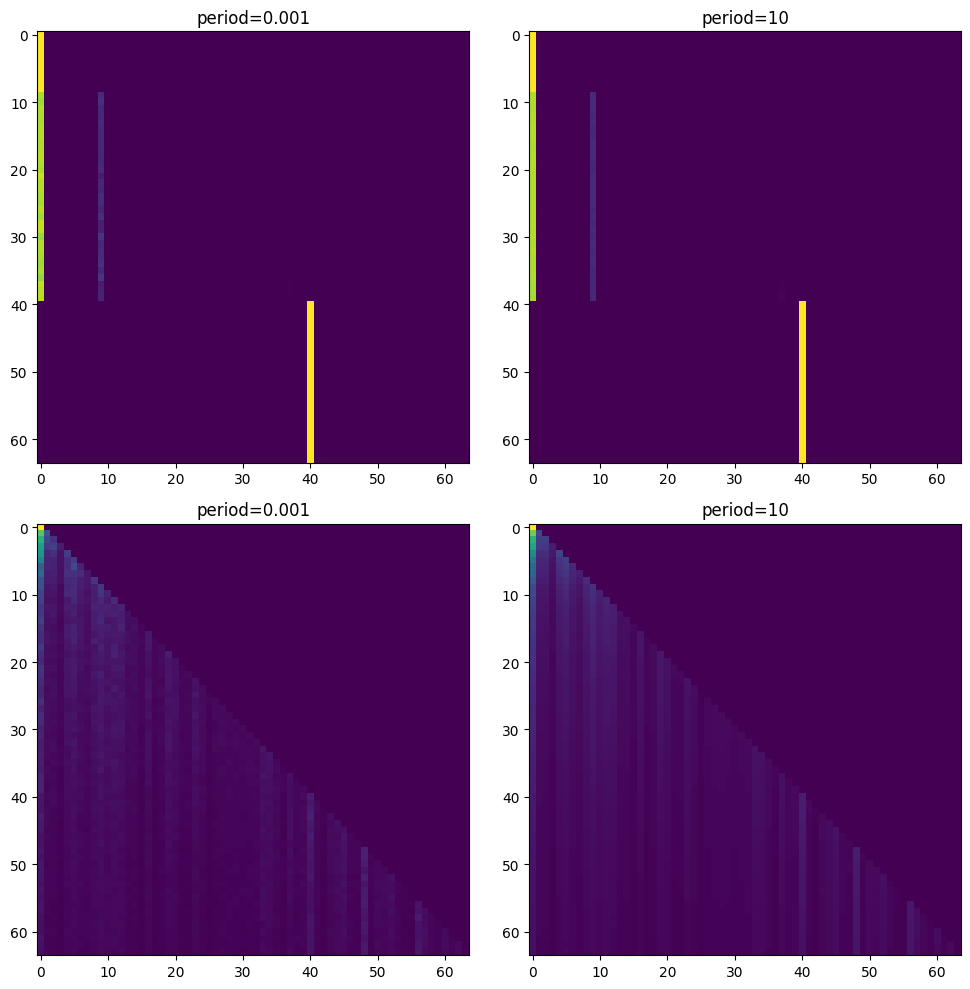

In [12]:
fig, (row_ax1, row_ax2) = plt.subplots(2, len(periods), figsize=(5*len(periods), 10))

for ax, period, attn in zip(row_ax1, periods, Per_kernelsL1):
    ax.imshow(attn.attention_weight.squeeze())
    ax.set_title(f'period={period}')

for ax, period, attn in zip(row_ax2, periods, Per_kernelsL2):
    ax.imshow(attn.attention_weight.squeeze())
    ax.set_title(f'period={period}')

plt.tight_layout()

Text(0.5, 1.0, 'L2 periodic last attention row')

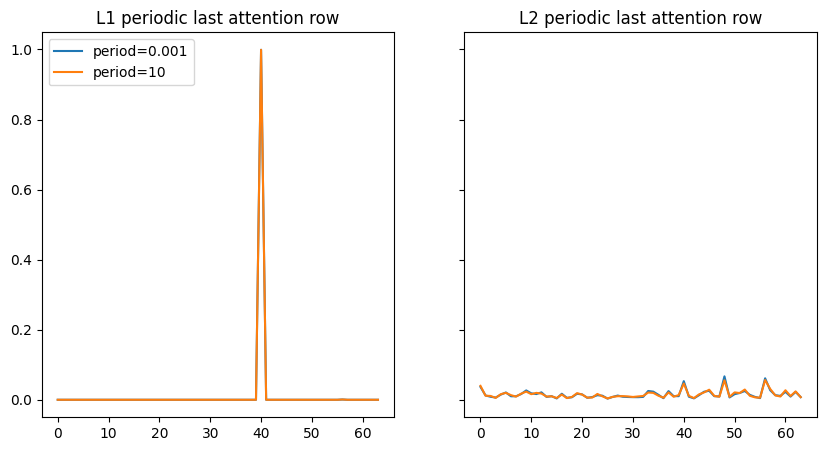

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for p, kernel in zip(periods, Per_kernelsL1):
    for w in kernel.attention_weight.squeeze()[-1:]:
        ax1.plot(w.detach().squeeze(), label=f'period={p}')

ax1.legend()
ax1.set_title("L1 periodic last attention row")

for kernel in Per_kernelsL2:
    for w in kernel.attention_weight.squeeze()[-1:]:
        ax2.plot(w.detach().squeeze())

ax2.set_title("L2 periodic last attention row")


### Locally Periodic kernel

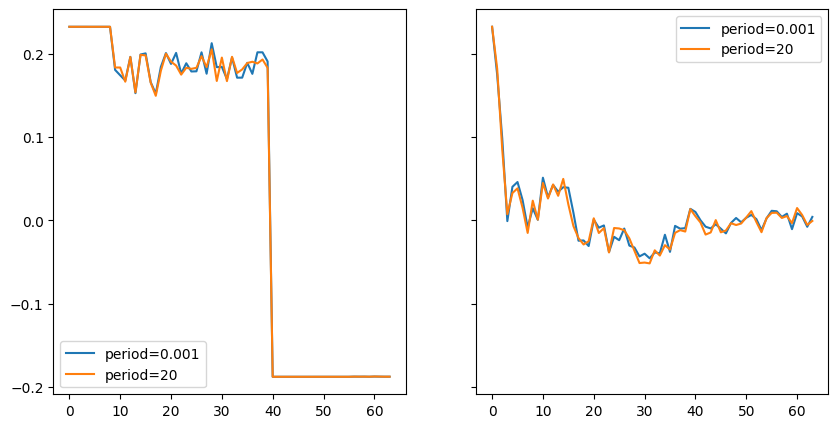

In [14]:
periods = [0.001, 20]

LP_kernelsL1 = [KA.LocallyPeriodicKernelAttention(p_norm=1, period=p, include_magnitude=True) for p in periods]
for attn in LP_kernelsL1:
    attn.eval()

LP_kernelsL2 = [KA.LocallyPeriodicKernelAttention(p_norm=1, period=p, include_magnitude=False) for p in periods]
for attn in LP_kernelsL2:
    attn.eval()

ys1 = [attn(q, k, v, mask) for attn in LP_kernelsL1]
ys2 = [attn(q, k, v, mask) for attn in LP_kernelsL2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for p, y in zip(periods, ys1):
    ax1.plot(y.detach().squeeze().mean(dim=-1), label=f'period={p}')

for p, y in zip(periods, ys2):
    ax2.plot(y.detach().squeeze().mean(dim=-1), label=f'period={p}')

ax1.legend()
ax2.legend()

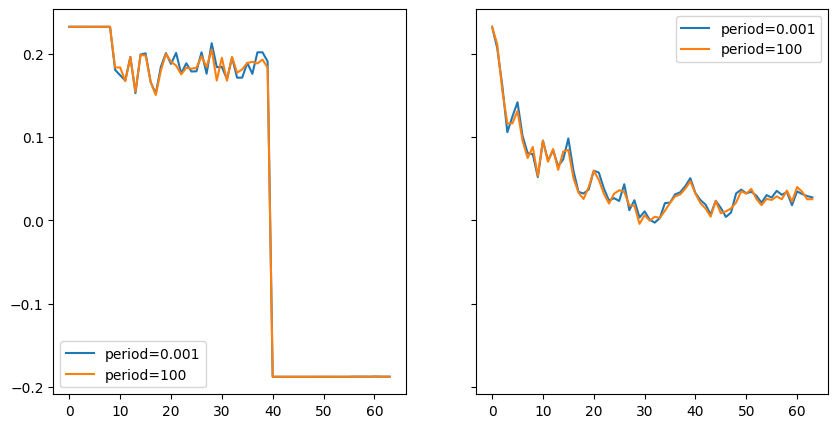

In [15]:
periods = [0.001, 100]

LP_kernelsL1 = [KA.LocallyPeriodicKernelAttention(p_norm=1, period=p) for p in periods]
for attn in LP_kernelsL1:
    attn.eval()

LP_kernelsL2 = [KA.LocallyPeriodicKernelAttention(p_norm=2, period=p) for p in periods]
for attn in LP_kernelsL2:
    attn.eval()

ys1 = [attn(q, k, v, mask) for attn in LP_kernelsL1]
ys2 = [attn(q, k, v, mask) for attn in LP_kernelsL2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for p, y in zip(periods, ys1):
    ax1.plot(y.detach().squeeze().mean(dim=-1), label=f'period={p}')

for p, y in zip(periods, ys2):
    ax2.plot(y.detach().squeeze().mean(dim=-1), label=f'period={p}')

ax1.legend()
ax2.legend()

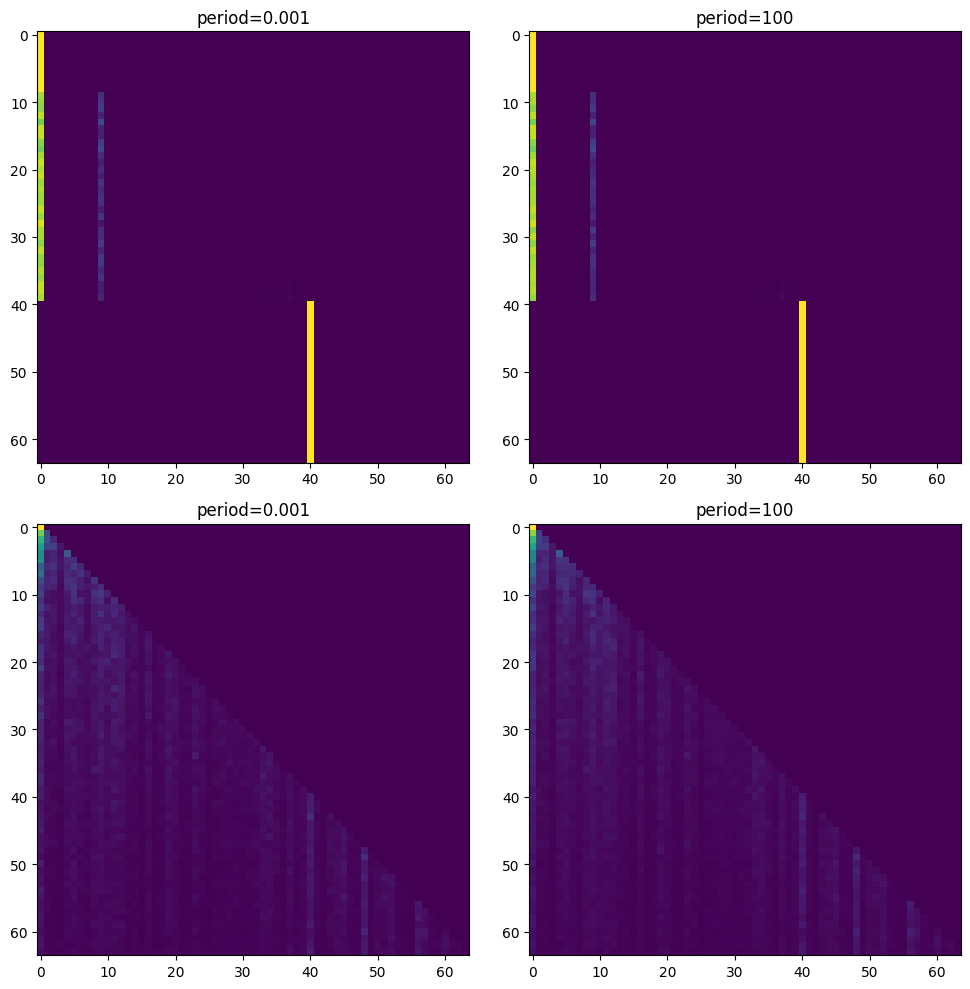

In [16]:
fig, (row_ax1, row_ax2) = plt.subplots(2, len(periods), figsize=(5*len(periods), 10))

for ax, period, attn in zip(row_ax1, periods, LP_kernelsL1):
    ax.imshow(attn.attention_weight.squeeze())
    ax.set_title(f'period={period}')

for ax, period, attn in zip(row_ax2, periods, LP_kernelsL2):
    ax.imshow(attn.attention_weight.squeeze())
    ax.set_title(f'period={period}')

plt.tight_layout()

Text(0.5, 1.0, 'L2 periodic last attention row')

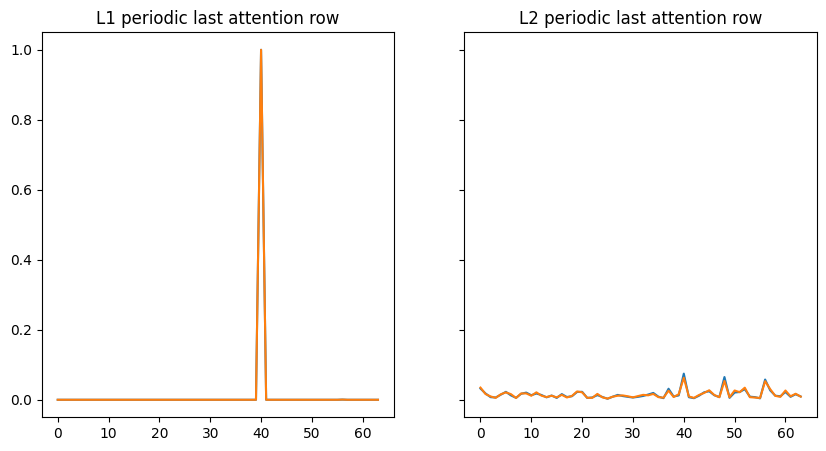

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for kernel in LP_kernelsL1:
    for w in kernel.attention_weight.squeeze()[-1:]:
        ax1.plot(w.detach().squeeze())

ax1.set_title("L1 periodic last attention row")

for kernel in LP_kernelsL2:
    for w in kernel.attention_weight.squeeze()[-1:]:
        ax2.plot(w.detach().squeeze())

ax2.set_title("L2 periodic last attention row")


### Rational Quadratic kernel

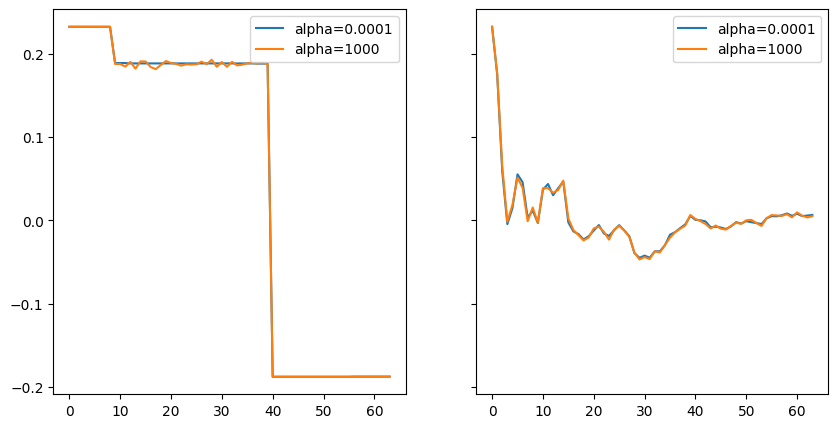

In [19]:
alphas = [0.0001, 1000]

RQ_kernelsL1 = [KA.RationalQuadraticKernelAttention(p_norm=1, alpha=a, include_magnitude=True) for a in alphas]
for attn in RQ_kernelsL1:
    attn.eval()

RQ_kernelsL2 = [KA.RationalQuadraticKernelAttention(p_norm=1, alpha=a, include_magnitude=False) for a in alphas]
for attn in RQ_kernelsL2:
    attn.eval()

ys1 = [attn(q, k, v, mask) for attn in RQ_kernelsL1]
ys2 = [attn(q, k, v, mask) for attn in RQ_kernelsL2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for a, y in zip(alphas, ys1):
    ax1.plot(y.detach().squeeze().mean(dim=-1), label=f'alpha={a}')

for a, y in zip(alphas, ys2):
    ax2.plot(y.detach().squeeze().mean(dim=-1), label=f'alpha={a}')

ax1.legend()
ax2.legend()

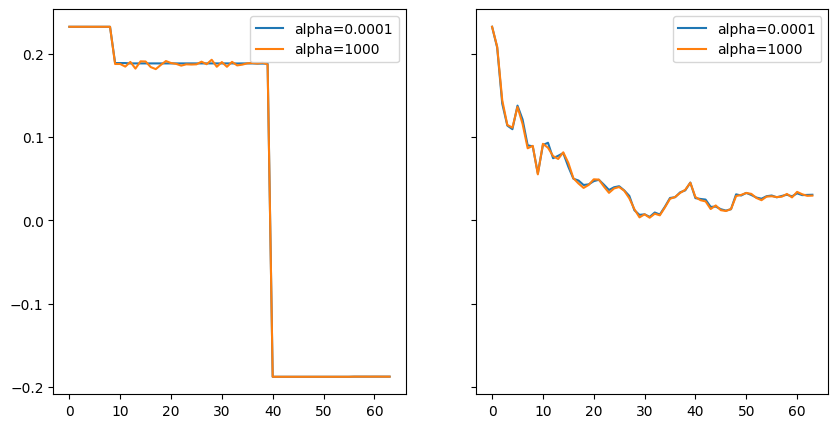

In [20]:
alphas = [0.0001, 1000]

RQ_kernelsL1 = [KA.RationalQuadraticKernelAttention(p_norm=1, alpha=a) for a in alphas]
for attn in RQ_kernelsL1:
    attn.eval()

RQ_kernelsL2 = [KA.RationalQuadraticKernelAttention(p_norm=2, alpha=a) for a in alphas]
for attn in RQ_kernelsL2:
    attn.eval()

ys1 = [attn(q, k, v, mask) for attn in RQ_kernelsL1]
ys2 = [attn(q, k, v, mask) for attn in RQ_kernelsL2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for a, y in zip(alphas, ys1):
    ax1.plot(y.detach().squeeze().mean(dim=-1), label=f'alpha={a}')

for a, y in zip(alphas, ys2):
    ax2.plot(y.detach().squeeze().mean(dim=-1), label=f'alpha={a}')

ax1.legend()
ax2.legend()

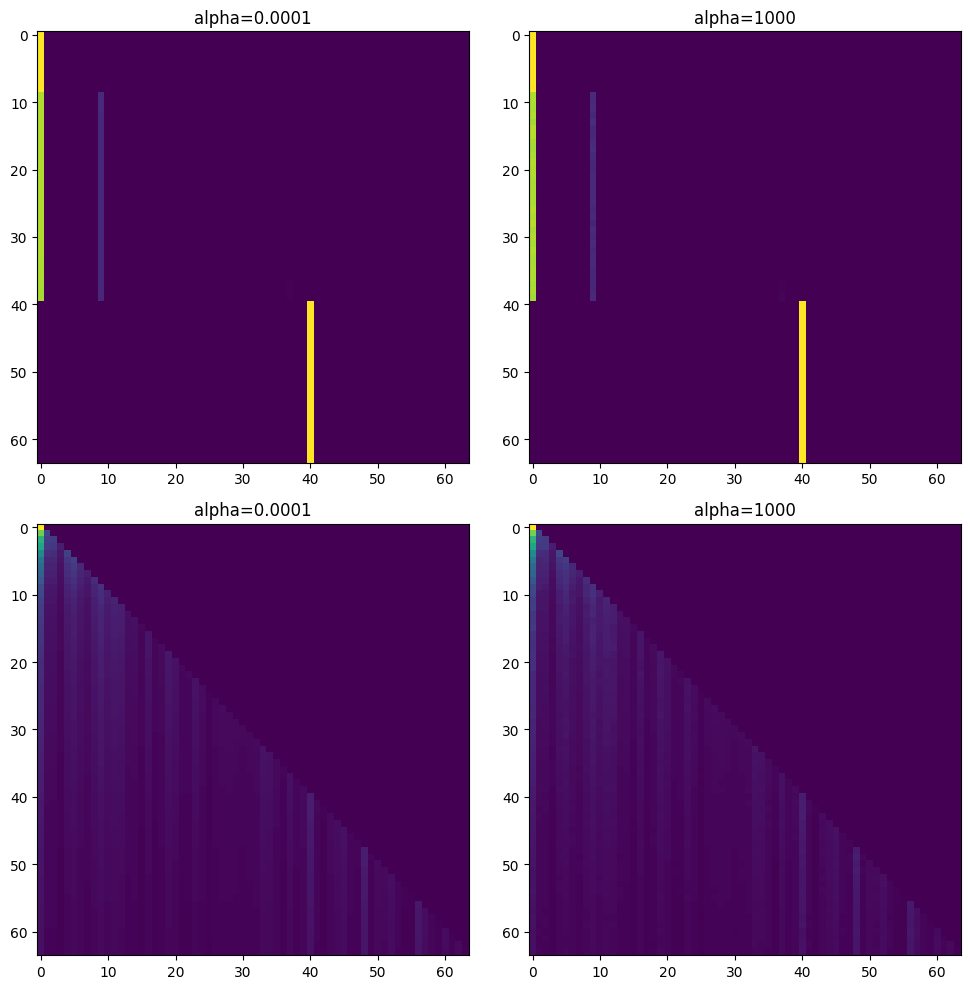

In [21]:
fig, (row_ax1, row_ax2) = plt.subplots(2, len(alphas), figsize=(5*len(alphas), 10))

for ax, a, attn in zip(row_ax1, alphas, RQ_kernelsL1):
    ax.imshow(attn.attention_weight.squeeze())
    ax.set_title(f'alpha={a}')

for ax, a, attn in zip(row_ax2, alphas, RQ_kernelsL2):
    ax.imshow(attn.attention_weight.squeeze())
    ax.set_title(f'alpha={a}')

plt.tight_layout()

Text(0.5, 1.0, 'L2 RQ last attention row')

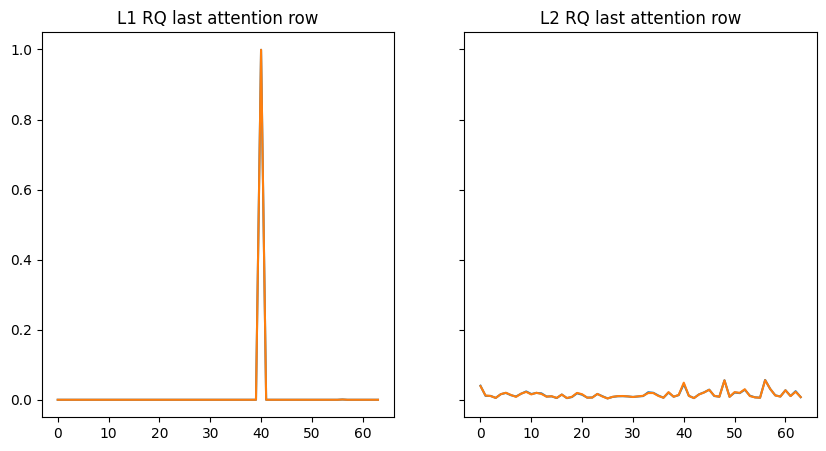

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for kernel in RQ_kernelsL1:
    for w in kernel.attention_weight.squeeze()[-1:]:
        ax1.plot(w.detach().squeeze())

ax1.set_title("L1 RQ last attention row")

for kernel in RQ_kernelsL2:
    for w in kernel.attention_weight.squeeze()[-1:]:
        ax2.plot(w.detach().squeeze())

ax2.set_title("L2 RQ last attention row")


### Change point kernel

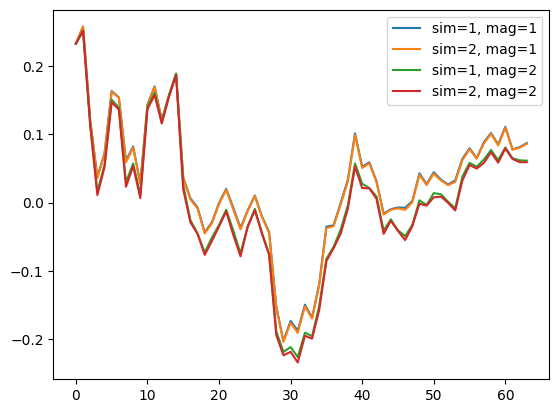

In [23]:
CP_kernels = [
    KA.ChangePointKernelAttention(p_norm_sim=1, p_norm_mag=1, period=20),
    KA.ChangePointKernelAttention(p_norm_sim=2, p_norm_mag=1, period=20),
    KA.ChangePointKernelAttention(p_norm_sim=1, p_norm_mag=2, period=20),
    KA.ChangePointKernelAttention(p_norm_sim=2, p_norm_mag=2, period=20),
]

for attn in CP_kernels:
    attn.eval()

ys = [attn(q, k, v, mask) for attn in CP_kernels]

for attn, y in zip(CP_kernels, ys):
    plt.plot(y.detach().squeeze().mean(dim=-1), label=f'sim={attn.p_norm_sim}, mag={attn.p_norm_mag}')

plt.legend()

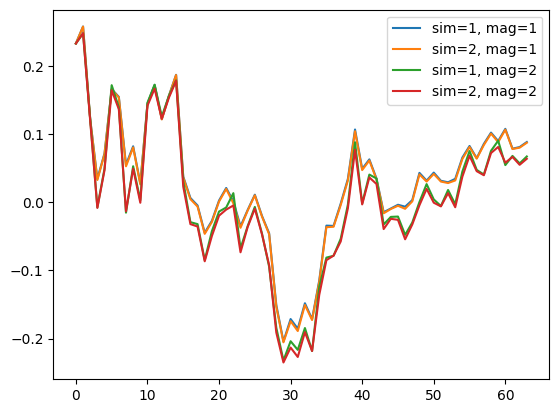

In [24]:
CP_kernels = [
    KA.ChangePointKernelAttention(p_norm_sim=1, p_norm_mag=1, period=0.00001),
    KA.ChangePointKernelAttention(p_norm_sim=2, p_norm_mag=1, period=0.00001),
    KA.ChangePointKernelAttention(p_norm_sim=1, p_norm_mag=2, period=0.00001),
    KA.ChangePointKernelAttention(p_norm_sim=2, p_norm_mag=2, period=0.00001),
]

for attn in CP_kernels:
    attn.eval()

ys = [attn(q, k, v, mask) for attn in CP_kernels]

for attn, y in zip(CP_kernels, ys):
    plt.plot(y.detach().squeeze().mean(dim=-1), label=f'sim={attn.p_norm_sim}, mag={attn.p_norm_mag}')

plt.legend()

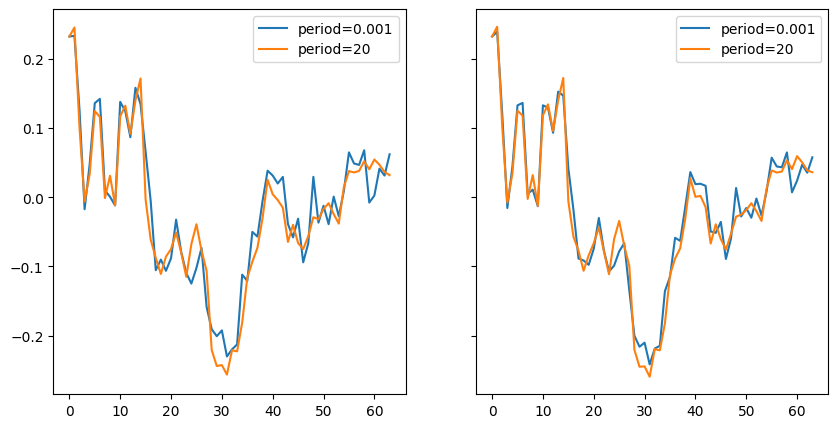

In [26]:
periods = [0.001, 20]

CP_kernelsL1 = [KA.ChangePointKernelAttention(p_norm_sim=1, period=p, include_magnitude=False) for p in periods]
for attn in CP_kernelsL1:
    attn.eval()

CP_kernelsL2 = [KA.ChangePointKernelAttention(p_norm_sim=2, period=p, include_magnitude=False) for p in periods]
for attn in CP_kernelsL2:
    attn.eval()

ys1 = [attn(q, k, v, mask) for attn in CP_kernelsL1]
ys2 = [attn(q, k, v, mask) for attn in CP_kernelsL2]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for p, y in zip(periods, ys1):
    ax1.plot(y.detach().squeeze().mean(dim=-1), label=f'period={p}')

for p, y in zip(periods, ys2):
    ax2.plot(y.detach().squeeze().mean(dim=-1), label=f'period={p}')

ax1.legend()
ax2.legend()

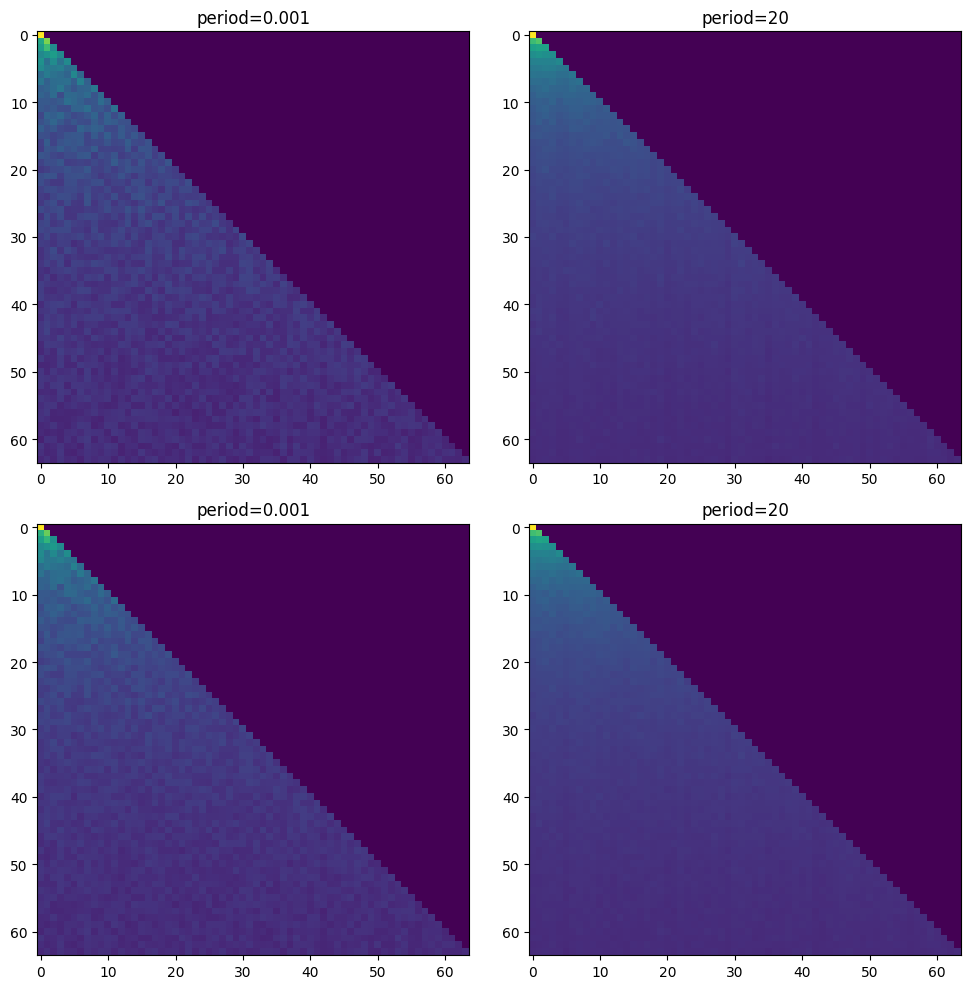

In [27]:
fig, (row_ax1, row_ax2) = plt.subplots(2, len(periods), figsize=(5*len(periods), 10))

for ax, period, attn in zip(row_ax1, periods, CP_kernelsL1):
    ax.imshow(attn.attention_weight.squeeze())
    ax.set_title(f'period={period}')

for ax, period, attn in zip(row_ax2, periods, CP_kernelsL2):
    ax.imshow(attn.attention_weight.squeeze())
    ax.set_title(f'period={period}')

plt.tight_layout()

Text(0.5, 1.0, 'L2 Changepoint last attention row')

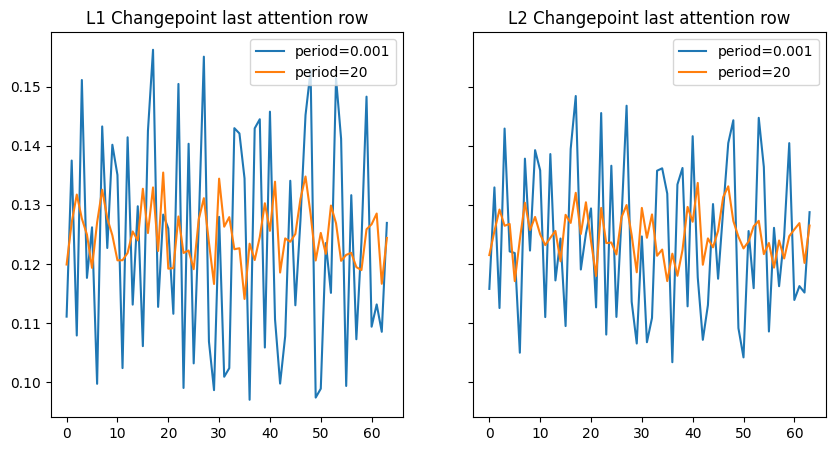

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for p, kernel in zip(periods, CP_kernelsL1):
    for w in kernel.attention_weight.squeeze()[-1:]:
        ax1.plot(w.detach().squeeze(), label=f'period={p}')

ax1.legend()
ax1.set_title("L1 Changepoint last attention row")

for p, kernel in zip(periods, CP_kernelsL2):
    for w in kernel.attention_weight.squeeze()[-1:]:
        ax2.plot(w.detach().squeeze(), label=f'period={p}')

ax2.legend()
ax2.set_title("L2 Changepoint last attention row")
